In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import shutil
from sklearn.model_selection import train_test_split

cudnn.benchmark = True
plt.ion()  # interactive mode

print("라이브러리 임포트 완료!")

라이브러리 임포트 완료!


In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# ZIP 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/sample_computer_vision.zip'

# 파일 존재 확인
if os.path.exists(zip_file_path):
    print(f"✓ ZIP 파일 발견: {zip_file_path}")

    # 압축 해제
    !unzip -q -o "{zip_file_path}" -d /content/
    print("✓ 압축 해제 완료!")
else:
    print(f"✗ 파일을 찾을 수 없습니다: {zip_file_path}")
    print("\n드라이브 구조 확인:")
    !ls -la "/content/drive/MyDrive/Colab Notebooks/"

# 현재 구조 확인
print("\n현재 폴더 구조:")
!ls -la /content/

# sample_computer_vision 폴더 확인
if os.path.exists('/content/sample_computer_vision'):
    print("\n/content/sample_computer_vision 내용:")
    !ls -la /content/sample_computer_vision/
else:
    print("\n압축 해제 후 생성된 폴더:")
    !ls -la /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ ZIP 파일 발견: /content/drive/MyDrive/Colab Notebooks/sample_computer_vision.zip
✓ 압축 해제 완료!

현재 폴더 구조:
total 24
drwxr-xr-x 1 root root 4096 Nov  3 11:16 .
drwxr-xr-x 1 root root 4096 Nov  3 11:05 ..
drwxr-xr-x 4 root root 4096 Oct 30 13:36 .config
drwx------ 5 root root 4096 Nov  3 11:14 drive
drwxrwxrwx 4 root root 4096 Oct 29 11:56 sample_computer_vision
drwxr-xr-x 1 root root 4096 Oct 30 13:36 sample_data

/content/sample_computer_vision 내용:
total 16
drwxrwxrwx 4 root root 4096 Oct 29 11:56 .
drwxr-xr-x 1 root root 4096 Nov  3 11:16 ..
drwxrwxrwx 4 root root 4096 Oct 29 12:19 train
drwxrwxrwx 4 root root 4096 Oct 29 12:19 val


In [7]:
# 경로 설정
base_dir = '/content/sample_computer_vision'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# train 폴더 내 클래스 확인
classes = [d for d in os.listdir(train_dir)
           if os.path.isdir(os.path.join(train_dir, d)) and not d.startswith('.')]
print(f"발견된 클래스: {classes}")

# 각 클래스별 이미지 개수 확인
for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    images = [f for f in os.listdir(cls_path)
             if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')]
    print(f"{cls}: {len(images)}개 이미지")

# val 디렉토리 생성
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    print(f"\n✓ Validation 폴더 생성: {val_dir}")

# 각 클래스별로 train/val 분할 (80:20)
for class_name in classes:
    # 경로 설정
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    # val 클래스 폴더 생성
    if not os.path.exists(val_class_dir):
        os.makedirs(val_class_dir)

    # 이미지 파일 목록
    all_images = [f for f in os.listdir(train_class_dir)
                  if f.endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')]

    # 80:20 비율로 분할
    train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

    # validation 이미지 이동
    for img in val_images:
        src = os.path.join(train_class_dir, img)
        dst = os.path.join(val_class_dir, img)
        if os.path.exists(src):  # 중복 실행 방지
            shutil.move(src, dst)

    print(f"{class_name}: train={len(train_images)}, val={len(val_images)}")

print("\n✓ 데이터 분할 완료!")

발견된 클래스: ['cats', 'dogs']
cats: 500개 이미지
dogs: 502개 이미지
cats: train=400, val=100
dogs: train=401, val=101

✓ 데이터 분할 완료!


In [8]:
# 데이터 전처리 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터 경로 설정
data_dir = '/content/sample_computer_vision'

# 데이터셋 로드
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                               batch_size=4,
                                               shuffle=True,
                                               num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"✓ Using {device} device")
print(f"✓ Classes: {class_names}")
print(f"✓ Train dataset size: {dataset_sizes['train']}")
print(f"✓ Validation dataset size: {dataset_sizes['val']}")

✓ Using cuda:0 device
✓ Classes: ['cats', 'dogs']
✓ Train dataset size: 801
✓ Validation dataset size: 401


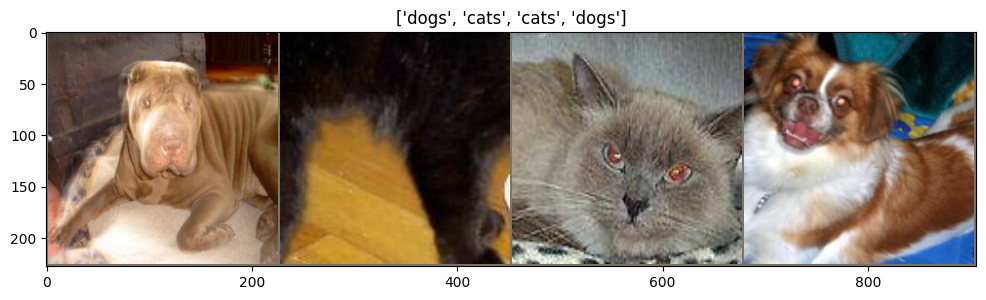

<Figure size 640x480 with 0 Axes>

✓ 데이터셋 시각화 완료! (결과물 1)


In [9]:
def imshow(inp, title=None):
    """Tensor 이미지 표시"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 학습 데이터 배치 가져오기
inputs, classes_batch = next(iter(dataloaders['train']))

# 그리드로 만들기
out = torchvision.utils.make_grid(inputs)

# 시각화
plt.figure(figsize=(12, 8))
imshow(out, title=[class_names[x] for x in classes_batch])
plt.savefig('dataset_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 데이터셋 시각화 완료! (결과물 1)")

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # 최고 모델 저장을 위한 임시 디렉토리 생성
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 각 에포크는 학습 및 검증 단계를 가짐
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 학습 모드
                else:
                    model.eval()   # 평가 모드

                running_loss = 0.0
                running_corrects = 0

                # 데이터 반복
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 파라미터 그래디언트 초기화
                    optimizer.zero_grad()

                    # forward
                    # 학습 시에만 그래디언트 추적
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize (학습 단계에서만)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # 통계
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 모델 깊은 복사
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 최고 모델 가중치 로드
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model

print("✓ 학습 함수 정의 완료!")

✓ 학습 함수 정의 완료!


In [11]:
# 사전 학습된 ResNet18 모델 로드
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# 마지막 fully connected layer를 2개 클래스로 수정
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # 고양이/개 = 2 클래스

model_ft = model_ft.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의 (모든 파라미터 최적화)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 학습률 스케줄러 (7 에포크마다 학습률을 0.1배로 감소)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 모델 학습 시작
print("=" * 60)
print("모델 학습 시작 (ResNet18 Fine-tuning)")
print("=" * 60)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

print("\n✓ 모델 학습 완료! (결과물 2)")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


모델 학습 시작 (ResNet18 Fine-tuning)
Epoch 0/24
----------
train Loss: 0.5970 Acc: 0.7503
val Loss: 0.6716 Acc: 0.7032

Epoch 1/24
----------
train Loss: 0.6202 Acc: 0.7516
val Loss: 0.1928 Acc: 0.9302

Epoch 2/24
----------
train Loss: 0.6682 Acc: 0.7566
val Loss: 0.2329 Acc: 0.9227

Epoch 3/24
----------
train Loss: 0.4523 Acc: 0.8152
val Loss: 0.1624 Acc: 0.9551

Epoch 4/24
----------
train Loss: 0.4479 Acc: 0.8340
val Loss: 0.1637 Acc: 0.9352

Epoch 5/24
----------
train Loss: 0.4630 Acc: 0.8090
val Loss: 0.1394 Acc: 0.9601

Epoch 6/24
----------
train Loss: 0.4183 Acc: 0.8240
val Loss: 0.1687 Acc: 0.9401

Epoch 7/24
----------
train Loss: 0.3470 Acc: 0.8639
val Loss: 0.1054 Acc: 0.9751

Epoch 8/24
----------
train Loss: 0.2918 Acc: 0.8702
val Loss: 0.0922 Acc: 0.9776

Epoch 9/24
----------
train Loss: 0.2913 Acc: 0.8801
val Loss: 0.0986 Acc: 0.9751

Epoch 10/24
----------
train Loss: 0.2864 Acc: 0.8876
val Loss: 0.1045 Acc: 0.9676

Epoch 11/24
----------
train Loss: 0.3101 Acc: 0.8602


예측 결과 시각화


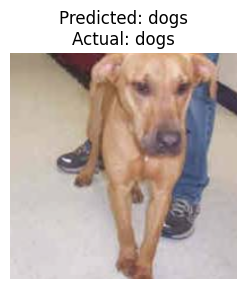

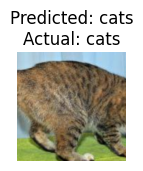

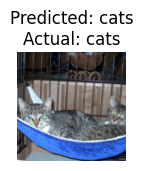

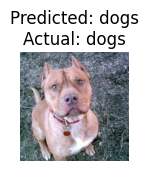

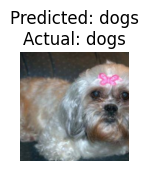

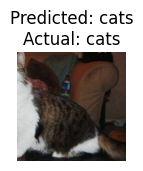

<Figure size 640x480 with 0 Axes>


✓ 예측 결과 시각화 완료! (결과물 3)


In [12]:
def visualize_model(model, num_images=6):
    """모델 예측 결과 시각화"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}',
                           fontsize=12)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
                    plt.show()
                    return

        model.train(mode=was_training)
        plt.tight_layout()
        plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
        plt.show()

# 예측 결과 시각화 (6장 이상)
print("=" * 60)
print("예측 결과 시각화")
print("=" * 60)
visualize_model(model_ft, num_images=6)

print("\n✓ 예측 결과 시각화 완료! (결과물 3)")

In [13]:
# 학습된 모델 저장
model_save_path = 'cat_dog_classifier.pth'
torch.save(model_ft.state_dict(), model_save_path)
print(f"✓ 모델 저장 완료: {model_save_path}")

# 최종 성능 평가
model_ft.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f"\n최종 Validation 정확도: {final_accuracy:.2f}%")

✓ 모델 저장 완료: cat_dog_classifier.pth

최종 Validation 정확도: 98.00%
